import library

In [73]:
import os
import random
import logging
import pickle
from typing import Tuple, Optional

import yaml
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

In [ ]:
class Config:
    """
    모든 실험 하이퍼파라미터는 외부 YAML 파일에서 불러옵니다.
    """

    def __init__(self, yaml_path: str):
        # YAML 파일 읽어서 파싱
        with open(yaml_path, 'r') as f:
            cfg = yaml.safe_load(f)

        # --- 데이터 관련 설정 ---
        self.DATA_ROOT       = cfg.get('data_root', './data')  # (YAML에 없으면 기본값)
        self.BATCH_SIZE      = cfg['data']['batch_size']
        self.NUM_WORKERS     = cfg['data']['num_workers']
        self.INPUT_SIZE      = cfg['data']['input_size']

        # --- 모델 관련 설정 ---
        # 예: cfg['model']['name'] == 'resnet18'
        self.MODEL_NAME      = cfg['model']['name']
        self.PRETRAINED      = cfg['model']['pretrained']
        self.FEATURE_EXTRACT = cfg['model']['feature_extract']
        self.MODEL_CHECKPOINT = cfg['model']['model_checkpoint']

        # --- 학습(패치 최적화) 관련 설정 ---
        training_cfg = cfg['training']
        self.OPTIMIZER       = training_cfg['optimizer']
        self.LR              = training_cfg['lr']
        self.MOMENTUM        = training_cfg['momentum']
        self.WEIGHT_DECAY    = training_cfg['weight_decay']
        self.SCHEDULER       = training_cfg['scheduler']
        self.STEP_SIZE       = training_cfg['step_size']
        self.GAMMA           = training_cfg['gamma']
        self.NUM_EPOCHS      = training_cfg['epochs']

        # --- Augmentation 관련 설정(사용하지 않을 수도 있으니 참고용) ---
        self.AUG_RANDOM_FLIP = cfg['augmentation']['random_flip']
        self.AUG_COLOR_JITTER= cfg['augmentation']['color_jitter']
        self.AUG_CUTMIX      = cfg['augmentation']['cutmix']

        # --- Early Stopping(평가) 설정(사용하지 않을 수도 있으니 참고용) ---
        self.ES_PATIENCE     = cfg['early_stopping']['patience']
        self.ES_VERBOSE      = cfg['early_stopping']['verbose']
        self.ES_DELTA        = cfg['early_stopping']['delta']
        self.ES_PATH         = cfg['early_stopping']['es_path']

        # --- 기타 Black-box 공격 관련 하이퍼파라미터 (기본값 지정) ---
        self.PATCH_CHECKPOINT   = cfg.get('patch_checkpoint', "untargeted_adv_patch.pt")
        self.LABEL_ENCODER_PATH = cfg.get('label_encoder_path', "label_encoder.pkl")
        self.DEVICE             = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.SEED               = cfg.get('seed', 42)
        self.PATCH_SIZE         = cfg.get('patch_size', 75)          # (없으면 기본 75×75)
        self.NOISE_SAMPLES      = cfg.get('noise_samples', 20)       # NES 노이즈 개수
        self.SIGMA              = cfg.get('sigma', 0.1)              # NES 표준편차
        self.MAX_QUERIES        = cfg.get('max_queries', 20000)      # 공격 시 최대 쿼리
        self.OCCLUSION_SIZE     = cfg.get('occlusion_size', 30)      # Occlusion patch size
        self.OCCLUSION_STRIDE   = cfg.get('occlusion_stride', 15)    # Occlusion stride
        self.GRADCAM_TARGET_LAYER = cfg.get('gradcam_target_layer', "layer4")
        self.SAVE_VIS_DIR       = cfg.get('save_vis_dir', "vis_results")

        # 저장 디렉터리 생성
        os.makedirs(self.SAVE_VIS_DIR, exist_ok=True)

    def __repr__(self):
        return f"<Config data_root={self.DATA_ROOT} batch_size={self.BATCH_SIZE} patch_size={self.PATCH_SIZE} lr={self.LR} epochs={self.NUM_EPOCHS}>"

# ──────────────────────────────────────────────────────────────────────────────
# 2) 모든 시드 고정
# ──────────────────────────────────────────────────────────────────────────────

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


In [75]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [76]:
def get_data_loader(data_root: str, batch_size: int, num_workers: int, input_size: int) -> Tuple[DataLoader, transforms.Compose]:
    """
    ImageFolder를 이용해 validation용 DataLoader를 생성합니다.
    """
    preprocess = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root=data_root, transform=preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return loader, preprocess

In [77]:
# Generalized-Mean Pooling (GeM)
# avgpool -> p-norm pooling

class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6): 
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return F.adaptive_avg_pool2d(x.clamp(min=self.eps).pow(self.p), (1,1)).pow(1./self.p)

In [78]:
def load_finetuned_resnet(num_classes: int,
                          model_name: str,
                          pretrained: bool,
                          checkpoint_path: str,
                          device: torch.device
                          ) -> nn.Module:
    """
    ResNet18 등을 불러와 fc 레이어만 num_classes 로 교체 후, checkpoint를 로드합니다.
    """
    if model_name.lower() == "resnet18":
        model = models.resnet18(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    
    # fc 레이어 교체
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    model.avgpool = GeM()
    
    # checkpoint 로드
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state)
    return model.to(device)

In [79]:
class GradCAM:
    def __init__(self, model: nn.Module, target_layer_name: str):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.fmap = None
        self.grad = None

        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                module.register_forward_hook(self._forward_hook)
                module.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.fmap = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.grad = grad_output[0].detach()

    def generate(self,
                 input_tensor: torch.Tensor,
                 target_class: Optional[int] = None
                 ) -> Tuple[np.ndarray, int]:
        """
        input_tensor: (1,3,H,W), Normalize 적용된 텐서
        target_class: None이면 모델이 예측한 top-1 사용
        return:
            heatmap_resized: (H, W) numpy 배열 (0~1)
            target_class: 사용한 class 인덱스
        """
        logits = self.model(input_tensor)
        probs = F.softmax(logits, dim=1)
        if target_class is None:
            _, target_class = torch.max(probs, dim=1)
            target_class = target_class.item()

        self.model.zero_grad()
        score = logits[0, target_class]
        score.backward(retain_graph=True)

        fmap = self.fmap[0]   # (C, h, w)
        grad = self.grad[0]   # (C, h, w)

        weights = torch.mean(grad.view(grad.shape[0], -1), dim=1)  # (C,)
        cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)  # (h, w)
        for i, w in enumerate(weights):
            cam += w * fmap[i, :, :]

        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()
        heatmap = cam.cpu().numpy()

        _, _, H, W = input_tensor.shape
        heatmap_resized = (
            Image.fromarray(np.uint8(heatmap * 255))
            .resize((W, H), resample=Image.BILINEAR)
        )
        heatmap_resized = np.array(heatmap_resized) / 255.0
        return heatmap_resized, target_class

In [80]:
def to_batch(tensor: torch.Tensor) -> torch.Tensor:
    if tensor.dim() == 3:
        return tensor.unsqueeze(0)
    elif tensor.dim() == 4:
        return tensor
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

In [81]:

def denormalize_tensor(tensor: torch.Tensor) -> np.ndarray:
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = tensor.cpu().permute(1, 2, 0).numpy()  # (H,W,3)
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

In [82]:
def adversarial_patch_attack_semiblend(model, data_loader, num_classes, label_encoder, config):
    device = config.DEVICE
    patch_size = config.PATCH_SIZE
    D = 3 * patch_size * patch_size

    # 1) 패치 초기화 (Tensor 형태로, [0,1] 범위)
    theta = torch.rand(D, device=device).clamp(0.0, 1.0)

    query_count = 0
    iteration = 0

    alpha = 0.5  # 투명도: 0.0→원본만, 1.0→패치만. 절충 값으로 0.3∼0.7 실험

    for epoch in range(config.NUM_EPOCHS):
        for images, labels in data_loader:
            if query_count >= config.MAX_QUERIES:
                break

            images = images.to(device)  # (B,3,224,224)
            labels = labels.to(device)
            B = images.size(0)

            # 2) 현재 패치 텐서 → (3,P,P)
            base_patch = theta.view(3, patch_size, patch_size)

            # 3) NES 노이즈 샘플링
            noise = torch.randn((config.NOISE_SAMPLES, D), device=device) * config.SIGMA
            grad_estimate = torch.zeros_like(theta)

            for i in range(config.NOISE_SAMPLES):
                if query_count >= config.MAX_QUERIES:
                    break

                eps = noise[i]
                theta_candidate = (theta + eps).clamp(0, 1)
                patch_candidate = theta_candidate.view(3, patch_size, patch_size)  # (3,P,P)

                total_loss = 0.0

                for idx in range(B):
                    img = images[idx]         # (3,224,224)
                    true_label = labels[idx].item()

                    # 4) 랜덤 위치 고르기 (쉽게 얼굴 중앙 가정하거나, 랜덤)
                    x0 = random.randint(0, config.INPUT_SIZE - patch_size)
                    y0 = random.randint(0, config.INPUT_SIZE - patch_size)

                    # 5) 반투명 블렌딩 적용
                    patched_img = img.clone()
                    orig_region = img[:, y0:y0+patch_size, x0:x0+patch_size]  # (3,P,P)
                    patched_region = (1 - alpha) * orig_region + alpha * patch_candidate
                    patched_img[:, y0:y0+patch_size, x0:x0+patch_size] = patched_region

                    # 6) 모델 예측 (softmax)
                    with torch.no_grad():
                        inp = patched_img.unsqueeze(0)  # (1,3,224,224)
                        probs = F.softmax(model(inp), dim=1).squeeze(0)

                    query_count += 1

                    # 7) Untargeted loss = -log(p_true)
                    loss_i = -torch.log(probs[true_label] + 1e-8)
                    total_loss += loss_i

                mean_loss = total_loss / B
                grad_estimate += (mean_loss * eps)

            # 8) NES gradient normalize + 업데이트
            grad_estimate = grad_estimate / (config.NOISE_SAMPLES * config.SIGMA)
            theta = (theta - config.LR * grad_estimate).clamp(0, 1)

            iteration += 1

            # 9) 로그 출력 (float 체크)
            if isinstance(mean_loss, torch.Tensor):
                loss_val = mean_loss.item()
            else:
                loss_val = mean_loss

            img0 = images[0]
            lbl0 = labels[0].item()
            with torch.no_grad():
                orig_prob = F.softmax(model(img0.unsqueeze(0)), dim=1)[0, lbl0].item()
                # 패치(반투명) 적용 예시
                patched0 = img0.clone()
                patched_region0 = (1 - alpha) * img0[:, y0:y0+patch_size, x0:x0+patch_size] + alpha * base_patch
                patched0[:, y0:y0+patch_size, x0:x0+patch_size] = patched_region0
                patched_prob = F.softmax(model(patched0.unsqueeze(0)), dim=1)[0, lbl0].item()

            logging.info(
                f"Epoch[{epoch+1}/{config.NUM_EPOCHS}] "
                f"Iter {iteration:04d} | loss {loss_val:.4f} | "
                f"orig_true {orig_prob:.4f}→patched_true {patched_prob:.4f} | "
                f"Queries {query_count}/{config.MAX_QUERIES}"
            )

            if query_count >= config.MAX_QUERIES:
                break
        if query_count >= config.MAX_QUERIES:
            break

    final_patch = theta.view(3, patch_size, patch_size).detach().cpu()
    torch.save(final_patch, config.PATCH_CHECKPOINT)
    logging.info(f"Final semi‐blend patch saved to {config.PATCH_CHECKPOINT}")
    return final_patch


In [83]:
def visualize_with_gradcam(model: nn.Module,
                           dataset_loader: DataLoader,
                           label_encoder,
                           final_patch: torch.Tensor,
                           config: Config
                           ) -> None:
    device = config.DEVICE
    grad_cam = GradCAM(model, target_layer_name=config.GRADCAM_TARGET_LAYER)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for ax in axes.flatten():
        img_tensor, true_label = next(iter(dataset_loader))
        img_tensor = img_tensor.squeeze(0).to(device)
        true_label = true_label.item()

        x0 = random.randint(0, config.INPUT_SIZE - config.PATCH_SIZE)
        y0 = random.randint(0, config.INPUT_SIZE - config.PATCH_SIZE)

        patched_img = img_tensor.clone()
        patched_img[:, y0:y0+config.PATCH_SIZE, x0:x0+config.PATCH_SIZE] = final_patch.to(device)

        with torch.no_grad():
            probs = F.softmax(model(to_batch(patched_img).to(device)), dim=1).squeeze(0).cpu().numpy()

        y_pred = int(np.argmax(probs))
        predicted_proba = probs[y_pred] * 100
        raw_pred_label = label_encoder.classes_[y_pred]
        pred_label = " ".join([w.capitalize() for w in raw_pred_label.split("_")])
        predicted_text = f"{pred_label} : {predicted_proba:.0f}%"

        raw_true_label = label_encoder.classes_[true_label]
        true_label_str = " ".join([w.capitalize() for w in raw_true_label.split("_")])
        actual_text = f"Actual: {true_label_str}"

        heatmap, _ = grad_cam.generate(to_batch(patched_img).to(device), target_class=None)

        img_np = denormalize_tensor(patched_img)
        ax.imshow(img_np)
        ax.axis("off")

        ax.imshow(heatmap, cmap="jet", alpha=0.4)

        #rect = patches.Rectangle((x0, y0), config.PATCH_SIZE, config.PATCH_SIZE,
        #                         linewidth=1, edgecolor="white", facecolor="none")
        #ax.add_patch(rect)

        ax.add_patch(patches.Rectangle((0, 0), 160, 40, color="white", alpha=0.8))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        ax.text(5, 20, predicted_text,
                horizontalalignment="left",
                fontproperties=font,
                verticalalignment="top",
                fontsize=9, color="black", fontweight="bold")
        ax.text(5, 40, actual_text,
                horizontalalignment="left",
                fontproperties=font,
                verticalalignment="top",
                fontsize=7, color="gray")

    plt.tight_layout()
    plt.show()
    save_path = os.path.join(config.SAVE_VIS_DIR, "gradcam_patch_visualization.png")
    plt.savefig(save_path)
    logging.info(f"Grad-CAM visualization saved to {save_path}")
    plt.close()

In [ ]:
# 1. Config 로딩
config = Config("adv_config.yaml")
print("Loaded config:", config)

# 2. 시드 고정
set_seed(config.SEED)


Loaded config: <Config data_root=C:/Users/alscj/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4/simpsons_dataset/simpsons_dataset batch_size=1 patch_size=75 lr=0.001 epochs=5>


In [85]:
# Validation DataLoader
val_loader, preprocess = get_data_loader(
    data_root=config.DATA_ROOT,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    input_size=config.INPUT_SIZE
)
print("Validation dataset size:", len(val_loader.dataset))

# LabelEncoder 로드
with open(config.LABEL_ENCODER_PATH, 'rb') as f:
    label_encoder = pickle.load(f)
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

Validation dataset size: 20933
Number of classes: 42


In [86]:
model = load_finetuned_resnet(
    num_classes=num_classes,
    model_name=config.MODEL_NAME,
    pretrained=config.PRETRAINED,
    checkpoint_path=config.MODEL_CHECKPOINT,
    device=config.DEVICE
)
model.eval()
print("Model loaded and ready.")

C:\Users\alscj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\alscj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\alscj\AppData\Local\Temp\ipykernel_5392\3880935340.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary c

Model loaded and ready.


In [87]:
final_patch = adversarial_patch_attack(
    model=model,
    data_loader=val_loader,
    num_classes=num_classes,
    label_encoder=label_encoder,
    config=config
)
print("Final patch shape:", final_patch.shape)


Final patch shape: torch.Size([3, 75, 75])


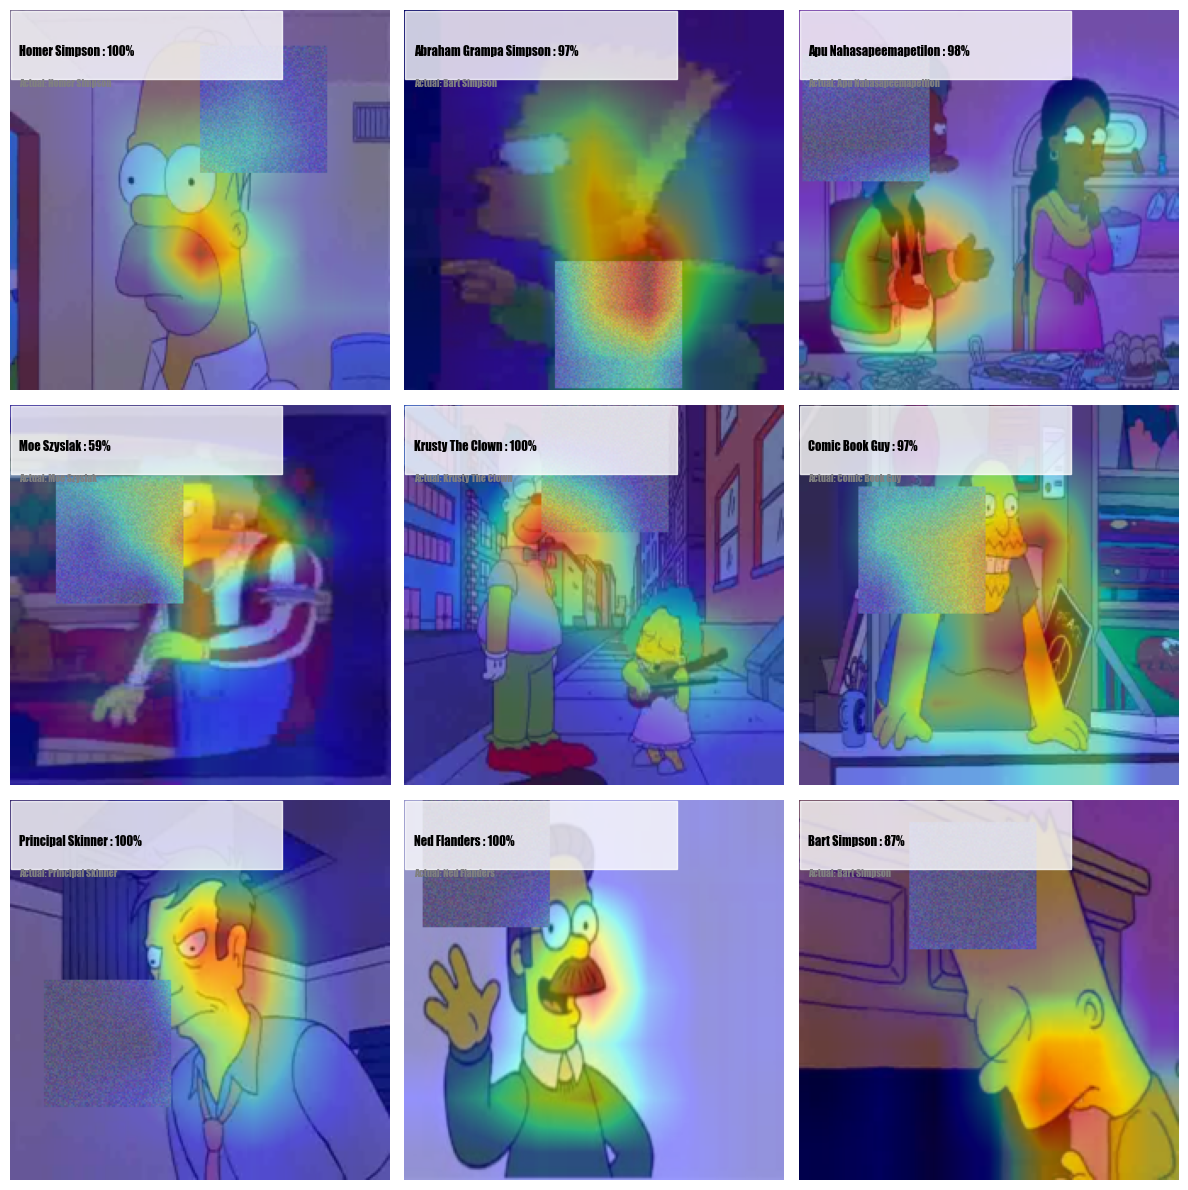

In [88]:
visualize_with_gradcam(
    model=model,
    dataset_loader=val_loader,
    label_encoder=label_encoder,
    final_patch=final_patch,
    config=config
)
